<a href="https://colab.research.google.com/github/FaiOnayq/Bootcamp_W4_Assignments/blob/main/Car_plates.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Saudi Arabia Car License Plate Detection and Recognition

## Imports

In [ ]:
pip install ultralytics


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 69.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 109.9 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langchain-community 0.0.20 requires numpy<2,>=1, but you have numpy 2.2.6 which is incompatible.
langchain 0.0.354 requires numpy<2,>=1, but you have numpy 2.2.6 which is incompatible.
xarray 2025.12.0 requires packaging>=24.1, but you have packaging 23.2 which is incompatible.
tensorflow 2.19.0 requires numpy<2.2.0,>=1.26.0, but you have numpy 2.2.6 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.

In [ ]:
import os
import yaml
import random
from ultralytics.data.utils import visualize_image_annotations
from ultralytics import YOLO


## Car Licence Plate Detection

### Load & Explore Dataset

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="H84tvWIecPgSWqGphiJd")
project = rf.workspace("cars-o2wwf").project("saudi-licence-plates")
version = project.version(3)
dataset = version.download("yolov11")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 38.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 88.4 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.12.0.88
    Uninstalling opencv-python-headless-4.12.0.88:
      Successfully uninstalled opencv-python-headless-4.12.0.88
  Attempting uninstall: idna
    Found existing installation: idna 3.11
    Uninstalling idna-3.11:
      Successfully uninstalled idna-3.11


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Saudi-Licence-Plates-3 in yolov11:: 100%|██████████| 9024/9024 [00:01<00:00, 8164.82it/s]


In [ ]:
DATASET_DIR = "/content/Saudi-Licence-Plates-3"
SPLITS = ["train", "valid", "test"]

def count_files(split):
    img_dir = os.path.join(DATASET_DIR, split, "images")
    lbl_dir = os.path.join(DATASET_DIR, split, "labels")

    images = [f for f in os.listdir(img_dir) if f.endswith((".jpg", ".png", ".jpeg"))]
    labels = [f for f in os.listdir(lbl_dir) if f.endswith(".txt")]

    return len(images), len(labels)

for split in SPLITS:
    imgs, lbls = count_files(split)
    print(f"{split}: {imgs} images, {lbls} labels")


train: 3599 images, 3599 labels
valid: 466 images, 466 labels
test: 441 images, 441 labels


In [ ]:
with open(os.path.join(DATASET_DIR, "data.yaml"), "r") as f:
    data = yaml.safe_load(f)

print("Classes:")
for i, name in enumerate(data["names"]):
    print(f"{i}: {name}")


Classes:
0: LP


In [ ]:
label_path = os.path.join(DATASET_DIR, "train", "labels")

sample_label = os.listdir(label_path)[0]

with open(os.path.join(label_path, sample_label)) as f:
    lines = f.readlines()

print(f"Label file: {sample_label}")
for line in lines:
    cls, xc, yc, w, h = map(float, line.split())
    print(f"Class {int(cls)} | bbox = ({xc:.2f}, {yc:.2f}, {w:.2f}, {h:.2f})")


Label file: 1678206184093_jpeg.rf.0f42868a4fad2866165425f7c1af8836.txt
Class 0 | bbox = (0.47, 0.56, 0.56, 0.37)


img_1340_jpg.rf.8eac0d996e9b702f345938c851981634.jpg


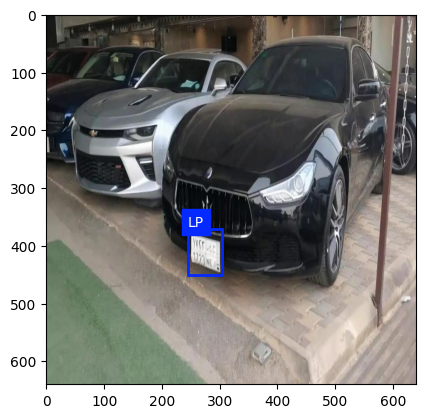

1672509067466_jpeg.rf.d8a3cccc21761c16b8e1662942eeadb2.jpg


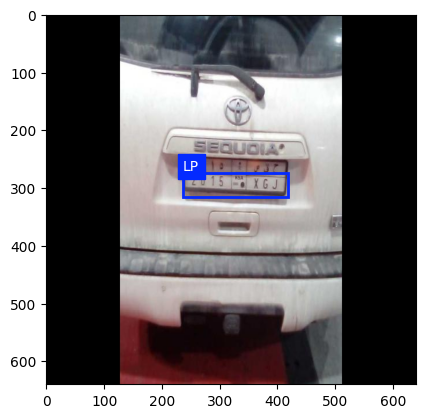

pic_441_jpg.rf.c64a22ef8e86593088ca5090bf2146eb.jpg


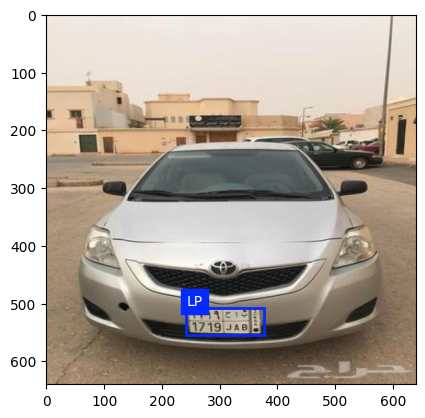

pic_339_jpg.rf.5154422184b9a10953eb4bbd7d5ac8f2.jpg


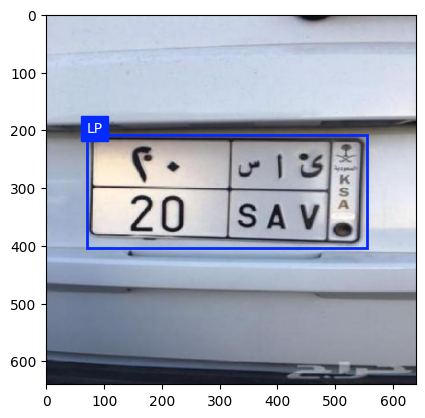

pic_72_jpg.rf.0fa84eebbf76b5fee22e7c14f7cefd1a.jpg


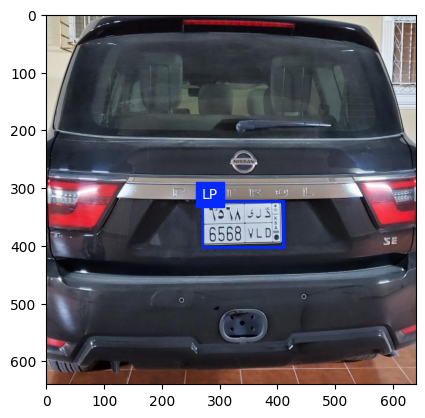

In [ ]:
label_map = {
    0: "LP"
}

split = random.choice(["train", "valid", "test"])

IMAGE_DIR = f"{DATASET_DIR}/{split}/images"
LABEL_DIR = f"{DATASET_DIR}/{split}/labels"

images = [f for f in os.listdir(IMAGE_DIR)
          if f.endswith((".jpg", ".png", ".jpeg"))]

for _ in range(5):
  img_name = random.choice(images)
  print(img_name)
  visualize_image_annotations(
      os.path.join(IMAGE_DIR, img_name),
      os.path.join(LABEL_DIR, os.path.splitext(img_name)[0] + ".txt"),
      label_map
  )




### Train model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
DATA_PATH = "/content/Saudi-Licence-Plates-3/data.yaml"
MODEL_TYPE = "yolo11s"
TASK = "detect"
IMG_SIZE = 640
EPOCHS = 50
BATCH_SIZE = 32
PROJECT= "/content/drive/MyDrive/Bootcamp/W4_DL/YOLO_runs"
SAVE_DIR = "/content/drive/MyDrive/Bootcamp/W4_DL/runs/train"


In [ ]:
model = YOLO(f"{MODEL_TYPE}.pt")
model.train(
    data=DATA_PATH,
    task=TASK,
    imgsz=IMG_SIZE,
    epochs=EPOCHS,
    batch=BATCH_SIZE,
    save=True,
    project=PROJECT,
    name=f"{MODEL_TYPE}_{TASK}",
)

Ultralytics 8.3.250 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/Saudi-Licence-Plates-3/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolo11s_detect, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f4bf44c2cf0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

## Crop Image

In [ ]:
MODEL_PATH = "/content/drive/MyDrive/Bootcamp/W4_DL/YOLO_runs/yolo11s_detect/weights/best.pt"
model = YOLO(MODEL_PATH)

### crop single image

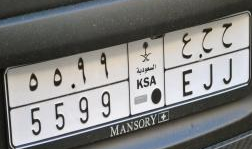

In [ ]:

def crop_best_detection(image_path, model):
    image = cv2.imread(image_path)
    results = model.predict(image_path, conf=0.25, verbose=False)

    if len(results[0].boxes) == 0:
        return None

    box = results[0].boxes[0]  # already sorted by confidence
    x1, y1, x2, y2 = map(int, box.xyxy[0])

    crop = image[y1:y2, x1:x2]
    return crop



image_path = "/content/ksa-1-2/test/images/22617664117_580dfdfa66_o_jpg.rf.293ed65566040bae0358caaec9317126.jpg"

cropped = crop_best_detection(image_path=image_path,model=model)
if cropped is not None:
  pil_img = Image.fromarray(cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB))
  display(pil_img)



## Car Licence Plate Recognition

### Train YOLOv11

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="H84tvWIecPgSWqGphiJd")
project = rf.workspace("carplates-vbjgu").project("ksa-1-hxosv")
version = project.version(2)
dataset = version.download("yolov11")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 91.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 133.9 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.12.0.88
    Uninstalling opencv-python-headless-4.12.0.88:
      Successfully uninstalled opencv-python-headless-4.12.0.88
  Attempting uninstall: idna
    Found existing installation: idna 3.11
    Uninstalling idna-3.11:
      Successfully uninstalled idna-3.11
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to ksa-1-2 in yolov11:: 100%|██████████| 3938/3938 [00:00<00:00, 11104.32it/s]


In [ ]:
from ultralytics import YOLO

model = YOLO("yolo11s.pt")

model.train(data="/content/ksa-1-2/data.yaml", task="detect", imgsz=320, epochs=50, batch=32, project="/content/drive/MyDrive/Bootcamp/W4_DL/YOLO_char_runs")


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.3.250 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/ksa-1-2/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=320, int8=False, iou=0.7, keras=Fal

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x78d89183ed20>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.0

In [ ]:
from ultralytics import YOLO

char_model = YOLO("/content/drive/MyDrive/Bootcamp/W4_DL/YOLO_char_runs/train/weights/best.pt")


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
def yolo_chars_to_text(results, class_map):
    boxes = results[0].boxes
    if boxes is None:
        return ""

    chars = []
    for box in boxes:
        cls = int(box.cls[0])
        x_center = box.xyxy[0][0].item()  # left x
        chars.append((x_center, class_map[cls]))

    # sort left → right
    chars.sort(key=lambda x: x[0])

    return "".join([c[1] for c in chars])


In [ ]:
CLASS_MAP = {
    0:"0", 1:"1", 2:"2", 3:"3", 4:"4",
    5:"5", 6:"6", 7:"7", 8:"8", 9:"9",
    10:"A", 11:"B", 12:"D", 13:"E",
    14:"G", 15:"H", 16:"J", 17:"K",
    18:"N", 19:"R", 20:"S", 21:"T",
    22:"U", 23:"V", 24:"X", 25:"Z"
}

results = char_model.predict(
    source="/content/ksa-1-2/test/images/6120d9ac6cd6f_-KSA-1011JAAcloserview-thumb-jpeg-1165e6449638b3b83fa542ae7bf558b4_jpeg.rf.110eab170d471cd78b8602ae5b168ee7.jpg",
    imgsz=320,
    conf=0.3,
    verbose=False
)

yolo_text = yolo_chars_to_text(results, CLASS_MAP)
print("YOLOv11:", yolo_text)


YOLOv11: 1011JAA


### Paddle OCR

In [ ]:
pip install "langchain<0.1.0" "langchain-community<0.1.0"


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 7.7 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of langchain-community to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of langchain-community to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
INFO: pip is looking at multiple versions of langchain-core to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of langchain-core to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might ne

In [ ]:
!pip install -q paddlepaddle
!pip install -q "paddleocr>=2.0.1"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.3/189.3 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.2/55.2 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.0/87.0 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 94.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 767.5/767.5 kB 66.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.7/68.7 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 127.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0

In [ ]:
from paddleocr import PaddleOCR
import cv2
import numpy

In [ ]:
from paddleocr import PaddleOCR
ocr = PaddleOCR(
    use_doc_orientation_classify=False,
    use_doc_unwarping=False,
    use_textline_orientation=False)

Creating model: ('PP-OCRv5_server_det', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `/root/.paddlex/official_models/PP-OCRv5_server_det`.
Creating model: ('PP-OCRv5_server_rec', None)
Using official model (PP-OCRv5_server_rec), the model files will be automatically downloaded and saved in `/root/.paddlex/official_models/PP-OCRv5_server_rec`.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

README.md: 0.00B [00:00, ?B/s]

inference.yml: 0.00B [00:00, ?B/s]

inference.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

.gitattributes: 0.00B [00:00, ?B/s]

inference.pdiparams:   0%|          | 0.00/84.4M [00:00<?, ?B/s]

In [ ]:
def paddleocr_text(image_path):
    result = ocr.predict(image_path)

    if not result or not result[0]:
        return ""
    print(result)
    texts = [line[1][0] for line in result[0]]
    return "".join(texts)

paddle_text = paddleocr_text("/content/ksa-1-2/test/images/6120d9ac6cd6f_-KSA-1011JAAcloserview-thumb-jpeg-1165e6449638b3b83fa542ae7bf558b4_jpeg.rf.110eab170d471cd78b8602ae5b168ee7.jpg")
print("PaddleOCR:", paddle_text)


[{'input_path': '/content/ksa-1-2/test/images/6120d9ac6cd6f_-KSA-1011JAAcloserview-thumb-jpeg-1165e6449638b3b83fa542ae7bf558b4_jpeg.rf.110eab170d471cd78b8602ae5b168ee7.jpg', 'page_index': None, 'doc_preprocessor_res': {'output_img': array([[[94, ..., 95],
        ...,
        [53, ..., 24]],

       ...,

       [[13, ..., 16],
        ...,
        [ 4, ...,  4]]], dtype=uint8)}, 'dt_polys': [array([[102,   5],
       ...,
       [102,  19]], dtype=int16), array([[181, 129],
       ...,
       [181, 150]], dtype=int16), array([[175, 148],
       ...,
       [175, 159]], dtype=int16), array([[ 97, 161],
       ...,
       [ 97, 181]], dtype=int16), array([[117, 160],
       ...,
       [117, 184]], dtype=int16), array([[174, 159],
       ...,
       [174, 171]], dtype=int16), array([[220, 157],
       ...,
       [217, 188]], dtype=int16)], 'model_settings': {'use_doc_preprocessor': False, 'use_textline_orientation': False}, 'text_det_params': {'limit_side_len': 64, 'limit_type': 'min',

In [ ]:
ocr = PaddleOCR(use_angle_cls=True, lang="en")

/tmp/ipython-input-520897203.py:1: DeprecationWarning: The parameter `use_angle_cls` has been deprecated and will be removed in the future. Please use `use_textline_orientation` instead.
  ocr = PaddleOCR(use_angle_cls=True, lang="en")
/usr/local/lib/python3.12/dist-packages/paddle/utils/cpp_extension/extension_utils.py:718: UserWarning: No ccache found. Please be aware that recompiling all source files may be required. You can download and install ccache from: https://github.com/ccache/ccache/blob/master/doc/INSTALL.md
  warnings.warn(warning_message)
Creating model: ('PP-LCNet_x1_0_doc_ori', None)
Using official model (PP-LCNet_x1_0_doc_ori), the model files will be automatically downloaded and saved in `/root/.paddlex/official_models/PP-LCNet_x1_0_doc_ori`.
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (

Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

inference.json: 0.00B [00:00, ?B/s]

.gitattributes: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

README.md: 0.00B [00:00, ?B/s]

inference.yml:   0%|          | 0.00/766 [00:00<?, ?B/s]

inference.pdiparams:   0%|          | 0.00/6.75M [00:00<?, ?B/s]

Creating model: ('UVDoc', None)
Using official model (UVDoc), the model files will be automatically downloaded and saved in `/root/.paddlex/official_models/UVDoc`.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

inference.yml:   0%|          | 0.00/330 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

inference.json: 0.00B [00:00, ?B/s]

.gitattributes: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

inference.pdiparams:   0%|          | 0.00/32.1M [00:00<?, ?B/s]

Creating model: ('PP-LCNet_x1_0_textline_ori', None)
Using official model (PP-LCNet_x1_0_textline_ori), the model files will be automatically downloaded and saved in `/root/.paddlex/official_models/PP-LCNet_x1_0_textline_ori`.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

inference.json: 0.00B [00:00, ?B/s]

.gitattributes: 0.00B [00:00, ?B/s]

inference.yml:   0%|          | 0.00/735 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

README.md: 0.00B [00:00, ?B/s]

inference.pdiparams:   0%|          | 0.00/6.74M [00:00<?, ?B/s]

Creating model: ('PP-OCRv5_server_det', None)
Using official model (PP-OCRv5_server_det), the model files will be automatically downloaded and saved in `/root/.paddlex/official_models/PP-OCRv5_server_det`.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

inference.yml:   0%|          | 0.00/903 [00:00<?, ?B/s]

inference.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

README.md: 0.00B [00:00, ?B/s]

.gitattributes: 0.00B [00:00, ?B/s]

inference.pdiparams:   0%|          | 0.00/87.9M [00:00<?, ?B/s]

Creating model: ('en_PP-OCRv5_mobile_rec', None)
Using official model (en_PP-OCRv5_mobile_rec), the model files will be automatically downloaded and saved in `/root/.paddlex/official_models/en_PP-OCRv5_mobile_rec`.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

README.md: 0.00B [00:00, ?B/s]

.gitattributes: 0.00B [00:00, ?B/s]

inference.json: 0.00B [00:00, ?B/s]

inference.yml: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

inference.pdiparams:   0%|          | 0.00/7.77M [00:00<?, ?B/s]

In [ ]:
from PIL import Image

In [ ]:
original_image = Image.open("/content/ksa-1-2/test/images/6120d9ac6cd6f_-KSA-1011JAAcloserview-thumb-jpeg-1165e6449638b3b83fa542ae7bf558b4_jpeg.rf.110eab170d471cd78b8602ae5b168ee7.jpg")
cropped_numpy_image = numpy.array(original_image)
cropped_numpy_image_rgb = cropped_numpy_image[:, :, ::-1].copy()

In [ ]:
result = ocr.predict(cropped_numpy_image_rgb)
result


[{'input_path': None,
  'page_index': None,
  'doc_preprocessor_res': {'output_img': array([[[94, ..., 95],
           ...,
           [53, ..., 24]],
   
          ...,
   
          [[13, ..., 16],
           ...,
           [ 4, ...,  4]]], dtype=uint8)},
  'dt_polys': [array([[102,   5],
          ...,
          [102,  19]], dtype=int16),
   array([[181, 129],
          ...,
          [181, 150]], dtype=int16),
   array([[175, 148],
          ...,
          [175, 159]], dtype=int16),
   array([[ 97, 161],
          ...,
          [ 97, 181]], dtype=int16),
   array([[117, 160],
          ...,
          [117, 184]], dtype=int16),
   array([[174, 159],
          ...,
          [174, 171]], dtype=int16),
   array([[220, 157],
          ...,
          [217, 188]], dtype=int16)],
  'model_settings': {'use_doc_preprocessor': False,
   'use_textline_orientation': False},
  'text_det_params': {'limit_side_len': 64,
   'limit_type': 'min',
   'thresh': 0.3,
   'max_side_limit': 4000,
   'bo

## Full PipeLine to inference One Image

Detected plate (Latin):  5 5 9 9 E J J
Detected plate (Arabic): ح ح ع ٩ ٩ ٥ ٥


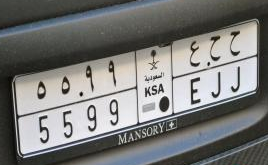

In [ ]:
from ultralytics import YOLO
import cv2
from PIL import Image
from IPython.display import display

# -----------------------------
# Model Paths
# -----------------------------
PLATE_MODEL_PATH = "/content/drive/MyDrive/Bootcamp/W4_DL/YOLO_runs/yolo11s_detect/weights/best.pt"
CHAR_MODEL_PATH  = "/content/drive/MyDrive/Bootcamp/W4_DL/YOLO_char_runs/train/weights/best.pt"

plate_model = YOLO(PLATE_MODEL_PATH)
char_model  = YOLO(CHAR_MODEL_PATH)

# -----------------------------
# Mapping: Model class (Latin) → Arabic
# Note: Your model outputs Latin labels like "A", "B", etc.
# We map them to Arabic script as per your table.
# -----------------------------
LATIN_TO_ARABIC = {
    "0": "٠", "1": "١", "2": "٢", "3": "٣", "4": "٤",
    "5": "٥", "6": "٦", "7": "٧", "8": "٨", "9": "٩",
    "A": "ا", "B": "ب", "D": "د", "E": "ع", "G": "ق",
    "H": "هـ", "J": "ح", "K": "ك", "N": "ن", "R": "ر",
    "S": "س", "T": "ط", "U": "و", "V": "ى", "X": "ص", "Z": "م"
}

# Original class-to-Latin mapping used by your char model
CLASS_TO_LATIN = {
    0:"0", 1:"1", 2:"2", 3:"3", 4:"4",
    5:"5", 6:"6", 7:"7", 8:"8", 9:"9",
    10:"A", 11:"B", 12:"D", 13:"E",
    14:"G", 15:"H", 16:"J", 17:"K",
    18:"N", 19:"R", 20:"S", 21:"T",
    22:"U", 23:"V", 24:"X", 25:"Z"
}


def detect_plate(image_path, model, conf=0.3):
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Image not found or unreadable: {image_path}")

    results = model.predict(source=image_path, conf=conf, imgsz=640, verbose=False)

    if not results or results[0].boxes is None or len(results[0].boxes) == 0:
        return None, None

    box = results[0].boxes[0]
    x1, y1, x2, y2 = map(int, box.xyxy[0])
    return image, (x1, y1, x2, y2)


def crop_plate(image, bbox, pad=8):
    x1, y1, x2, y2 = bbox
    h, w = image.shape[:2]
    x1 = max(0, x1 - pad)
    y1 = max(0, y1 - pad)
    x2 = min(w, x2 + pad)
    y2 = min(h, y2 + pad)
    return image[y1:y2, x1:x2]


def recognize_plate_chars(plate_img, model, conf=0.3):
    results = model.predict(source=plate_img, imgsz=320, conf=conf, verbose=False)

    if not results or results[0].boxes is None or len(results[0].boxes) == 0:
        return "", ""

    char_entries = []
    for box in results[0].boxes:
        cls_id = int(box.cls[0])
        x_center = float(box.xywh[0][0])  # center x for sorting
        latin_char = CLASS_TO_LATIN.get(cls_id, "?")
        arabic_char = LATIN_TO_ARABIC.get(latin_char, "?")
        char_entries.append((x_center, latin_char, arabic_char))

    # Sort left to right
    char_entries.sort(key=lambda x: x[0])

    latin_str = " ".join(entry[1] for entry in char_entries)
    arabic_str = " ".join(entry[2] for entry in reversed(char_entries))

    return latin_str, arabic_str


def recognize_plate(image_path):
    try:
        image, bbox = detect_plate(image_path, plate_model)
        if bbox is None:
            return None

        plate_crop = crop_plate(image, bbox)
        latin_text, arabic_text = recognize_plate_chars(plate_crop, char_model)

        return {
            "latin": latin_text,
            "arabic": arabic_text,
            "crop": plate_crop
        }

    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None


# -----------------------------
# Usage
# -----------------------------
image_path = "/content/ksa-1-2/test/images/22617664117_580dfdfa66_o_jpg.rf.293ed65566040bae0358caaec9317126.jpg"

result = recognize_plate(image_path)

if result:
    print("Detected plate (Latin): ", result["latin"])
    print("Detected plate (Arabic):", result["arabic"])

    pil_img = Image.fromarray(cv2.cvtColor(result["crop"], cv2.COLOR_BGR2RGB))
    display(pil_img)
else:
    print("No plate detected or error occurred.")

I know this could be better but I h